In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os
import tensorflow as tf

# keras module for building LSTM
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# csv file
df = pd.read_csv('/content/drive/MyDrive/DL_mp/data/lyrics-data.csv')

In [4]:
# first few rows
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [5]:
# drop
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)

In [6]:
# shape
df.shape

(379931, 2)

In [7]:
# take only english songs
# df = df[df['Idiom']=='ENGLISH']

In [8]:
# take first 700 rows
df = df[:700]

In [9]:
# shape
df.shape

(700, 2)

# Data Visualization

In [10]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

,Lyric,language,Number_of_words
0,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt,85
1,Meu coração\nSem direção\nVoando só por voar\n...,pt,140
2,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt,122
3,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt,158
4,A minha sorte grande foi você cair do céu\nMin...,pt,189


In [11]:
# statistical info
df['Number_of_words'].describe()

count    700.000000
mean     143.174286
std       82.766807
min        1.000000
25%       90.000000
50%      112.500000
75%      179.000000
max      580.000000
Name: Number_of_words, dtype: float64

### Frequency distribution of number of words

<ipython-input-12-8b69dec7c5b1>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

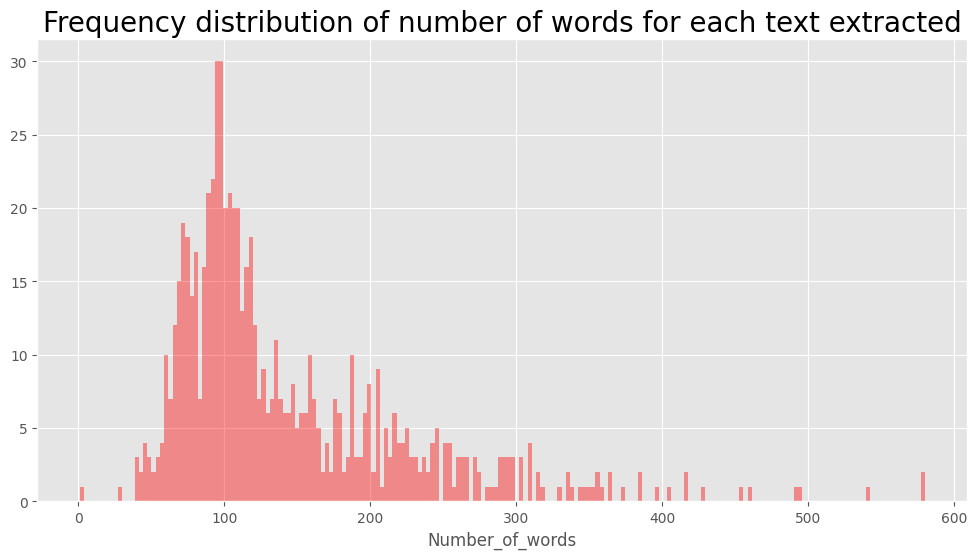

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

# Data Preprocessing

In [13]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
tokenized_sentences[0]

[39,
 3,
 1,
 2,
 23,
 193,
 46,
 72,
 46,
 8,
 8,
 40,
 7,
 40,
 7,
 3,
 24,
 12,
 8,
 45,
 55,
 256,
 1024,
 846,
 4,
 142,
 4,
 142,
 2,
 51,
 640,
 22,
 162,
 1,
 10,
 20,
 13,
 217,
 20,
 13,
 177,
 11,
 157,
 239,
 414,
 287,
 51,
 509,
 4,
 39,
 11,
 10,
 13,
 258,
 476,
 16,
 537,
 16,
 538,
 16,
 186,
 22,
 7,
 476,
 16,
 537,
 16,
 538,
 16,
 186,
 22,
 7,
 306,
 306,
 306,
 306,
 306,
 11,
 99,
 213,
 213,
 213,
 148,
 17,
 148,
 17,
 21,
 370]

In [14]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)

# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [15]:
input_sequences[:10]

array([[ 0,  0,  0, ...,  0, 39,  3],
       [ 0,  0,  0, ..., 39,  3,  1],
       [ 0,  0,  0, ...,  3,  1,  2],
       ...,
       [ 0,  0,  0, ..., 46, 72, 46],
       [ 0,  0,  0, ..., 72, 46,  8],
       [ 0,  0,  0, ..., 46,  8,  8]], dtype=int32)

In [16]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Model

In [17]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=10, verbose=1, callbacks=[earlystop])

Epoch 1/10
3121/3121 [==============================] - 271s 85ms/step - loss: 6.2942 - accuracy: 0.0575
Epoch 2/10
3121/3121 [==============================] - 196s 63ms/step - loss: 5.3145 - accuracy: 0.1214
Epoch 3/10
3121/3121 [==============================] - 194s 62ms/step - loss: 4.5768 - accuracy: 0.1865
Epoch 4/10
3121/3121 [==============================] - 192s 62ms/step - loss: 3.9343 - accuracy: 0.2583
Epoch 5/10
3121/3121 [==============================] - 193s 62ms/step - loss: 3.4162 - accuracy: 0.3253
Epoch 6/10
3121/3121 [==============================] - 191s 61ms/step - loss: 2.9914 - accuracy: 0.3876
Epoch 7/10
3121/3121 [==============================] - 191s 61ms/step - loss: 2.6504 - accuracy: 0.4434
Epoch 8/10
3121/3121 [==============================] - 191s 61ms/step - loss: 2.3676 - accuracy: 0.4935
Epoch 9/10
3121/3121 [==============================] - 188s 60ms/step - loss: 2.1390 - accuracy: 0.5325
Epoch 10/10
3121/3121 [==============================] 

Increase the epochs to increase the accuracy.I haven't done that because it is taking a very long time

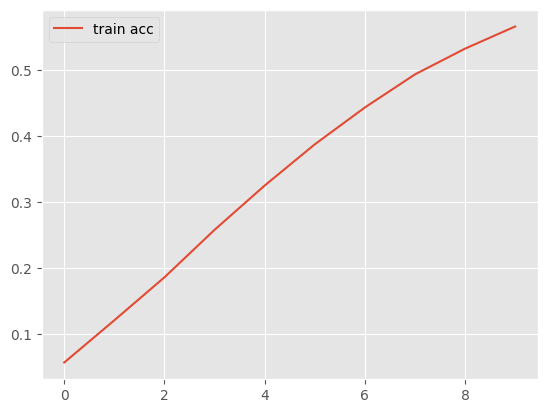

<Figure size 640x480 with 0 Axes>

In [18]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Generate new song lyrics

In [32]:
# def complete_this_song(seed_text, next_words):
#     for _ in range(next_words):
#         token_list = tokenizer.texts_to_sequences([seed_text])[0]
#         token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#         predicted = model.predict(token_list, verbose=0)

#         predicted_index = np.argmax(predicted)

#         output_word = ""
#         for word, index in tokenizer.word_index.items():
#             if index == predicted_index:
#                 output_word = word
#                 break
#         seed_text += " " + output_word
#     return seed_text

In [36]:
import random

def complete_this_song(seed_text, next_words, temperature=1.0):
    completed_song = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)[0]

        # Adjust the temperature of the predictions
        predicted = np.log(predicted) / temperature
        exp_predicted = np.exp(predicted)
        predicted = exp_predicted / np.sum(exp_predicted)

        # Sample from the probability distribution
        predicted_index = np.random.choice(len(predicted), p=predicted)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
        completed_song += " " + output_word
    return completed_song

completed_song = complete_this_song("this is the beginning", 140, temperature=0.5)
print(completed_song)

this is the beginning how let a one if i'm love it's true to see that it love you and be say that you need you that you need i don't believe in many things but in you i don't believe in many things but you that you don't know that it gets to all that you i don't believe in many things but in you i don't believe when i don't believe in many things but in you i don't believe in many things but in you i don't believe in it all that it gets to you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in me


Our function is ready so are you ready to generate your own lyrics

In [33]:
complete_this_song("the sky is blue", 40)

"the sky is blue in the world's full of problems they couldn't only only only only only only only only only only through through five for it aah for the things we'd just only just be right be be jammin' until the break of"

In [34]:
complete_this_song("This is the beginning", 140)

"This is the beginning how i don't believe in many things but in you i don't don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe in many things but in you i don't believe"

In [35]:
complete_this_song("I am missing you", 80)

"I am missing you and me all that you and me all we i'm easy like sunday morning yeah that's why i'm easy i'm easy like sunday morning whoa that's why i'm easy like sunday morning whoa that's why i'm easy i'm easy like sunday morning whoa that's why i'm easy i'm easy like sunday morning whoa that's why i'm easy i'm easy like sunday morning whoa that's why i'm easy i'm easy like sunday morning whoa that's why i'm easy i'm easy like"

# Save the model

In [ ]:
# save model
from tensorflow.keras.models import load_model
model.save('song_lyrics_generator.h5')

**Well that's done, in future I am going to update this notebook after learning more about text generation and don't forget to upvote it if you like it**
